# Gropup 31 Final Project
Luna Gulec, Farrel Ramdhani, Josh Homen, Yulin Yuan

# Import Library

In [1]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(leaps)
library(broom)
set.seed(123)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
✔ purrr     1.0.2     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked fro

In [2]:
diabetes <- read.csv("data/diabetes.csv")
head(diabetes)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0


# Introduction

Diabetes affects approximately 830 million people worldwide, with the majority living in low- and middle-income countries, and more than half live untreated (_Diabetes_, 2024). This poses a significant health concern because Type 2 diabetes, the most common type, can increase the risk of developing complications, such as cardiovascular disease, stroke, and chronic kidney disease (_Diabetes complications and risks_, 2024). 

One disproportionately affected population is the Pima Indians, an indigenous community residing in a hot desert environment in Arizona, USA, who have faced significant challenges in accessing adequate healthcare due to poor resources, low income, and unfavourable economic conditions, leading to delayed detection and inadequate management of chronic illnesses, particularly diabetes (Guan et al., 2024). Systematic glucose-tolerance tests conducted on this population revealed that the prevalence of diabetes mellitus is 50% among individuals aged 35 and older, making it the highest prevalence of diabetes ever recorded (Bennett et al., 2003). Additionally, earlier research by Knowler et al. (1993) on the Pima Indians showed that worsening glucose tolerance, especially in those with impaired glucose tolerance, is associated with "markedly higher incidence rates of diabetes". 

Therefore, given the increasing number of incidents and the fatal complications associated with untreated diabetes, continued research into the identification and prevention of diabetes is critical for improving health among the Pima Indians and other high-risk populations.

To explore this further, our project focuses on predicting diabetes using health metrics, such as Glucose and BMI, from a dataset provided by the National Institute of Diabetes and Digestive and Kidney Diseases, made up female patients aged 21+ of Pima Indian heritage, a group with a notably high prevalence of diabetes. 

Our primary question is: Which variables best predict diabetes, and to what extent do these metrics contribute to the likelihood of a diagnosis? Additionally, we aim to explore which specific predictors have the strongest association with diabetes, and how do these align with existing findings. 

To answer these questions, we will use logistic regression for binary classifications, exploring valuable insights into diabetes risk factors and and creating a model identifying the most significant predictors.

# Methods and Results

## EDA (Exploratory Data Analysis)

In [3]:
# Main developer: Luna 
# view the number of missing values for each variable
missing_values <- colSums(is.na(diabetes))
missing_values 

Pregnancies                  Glucose            BloodPressure 
                       0                        0                        0 
           SkinThickness                  Insulin                      BMI 
                       0                        0                        0 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0

After viewing missing_values, we can see that there are no missing values for any variable.

However, when we viewed some rows with head(diabetes), there were rows with zero values. 
- The presence of zeros in the dataset may indicate placeholders for missing data, as these values of certain health metrics generally shouldn’t be zero in health data, such as Glucose and Insulin; so, it’s reasonable to consider these zeros as placeholders for missing data. 
- If these are left in the model without treatment, it could lead to bias, especially in a logistic regression model sensitive to extreme values, by skewing distributions (i.e. falsely lower Insulin averages) and weaken the model’s predictive power.

Therefore, we can similarly check for such rows:

In [4]:
# Main developer: Luna 
# these columns are measurements which are generally unlikely to have 0 values (for instance unlike Pregnancies)
columns_with_zeros <- c("Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI")

zero_counts <- colSums(diabetes[columns_with_zeros] == 0)
zero_counts

Glucose BloodPressure SkinThickness       Insulin           BMI 
            5            35           227           374            11

We can now treat these zeros in these key predictor columns as missing values.

I decided to exclude rows with zero values, as these values could distort the analysis.
- _It's worthy to note that a possible issue with this method is that this might reduce our dataset size._

In [5]:
# Main developer: Luna 
# converting the zero values to NA
diabetes2 <- diabetes |>
    mutate_at(vars(all_of(columns_with_zeros)), ~na_if(., 0))

# dropping rows with NA
diabetes_cleaned <- diabetes2 |> drop_na(all_of(columns_with_zeros))
head(diabetes_cleaned)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,1,89,66,23,94,28.1,0.167,21,0
2,0,137,40,35,168,43.1,2.288,33,1
3,3,78,50,32,88,31.0,0.248,26,1
4,2,197,70,45,543,30.5,0.158,53,1
5,1,189,60,23,846,30.1,0.398,59,1
6,5,166,72,19,175,25.8,0.587,51,1


In [6]:
# Main developer: Luna 
# convert Outcome to a factor with levels "0" and "1"
diabetes_cleaned$Outcome <- factor(diabetes_cleaned$Outcome, levels = c(0, 1), labels = c("0", "1"))

# verify and check levels
str(diabetes_cleaned)
levels(diabetes_cleaned$Outcome)

'data.frame':	392 obs. of  9 variables:
 $ Pregnancies             : int  1 0 3 2 1 5 0 1 1 3 ...
 $ Glucose                 : int  89 137 78 197 189 166 118 103 115 126 ...
 $ BloodPressure           : int  66 40 50 70 60 72 84 30 70 88 ...
 $ SkinThickness           : int  23 35 32 45 23 19 47 38 30 41 ...
 $ Insulin                 : int  94 168 88 543 846 175 230 83 96 235 ...
 $ BMI                     : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ DiabetesPedigreeFunction: num  0.167 2.288 0.248 0.158 0.398 ...
 $ Age                     : int  21 33 26 53 59 51 31 33 32 27 ...
 $ Outcome                 : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 1 2 1 ...


[1] "0" "1"

Lastly, viewing summary statistics allows us to gauge potential outliers.

In [7]:
# Main developer: Luna 
summary(diabetes_cleaned)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   : 56.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.:21.00  
 Median : 2.000   Median :119.0   Median : 70.00   Median :29.00  
 Mean   : 3.301   Mean   :122.6   Mean   : 70.66   Mean   :29.15  
 3rd Qu.: 5.000   3rd Qu.:143.0   3rd Qu.: 78.00   3rd Qu.:37.00  
 Max.   :17.000   Max.   :198.0   Max.   :110.00   Max.   :63.00  
    Insulin            BMI        DiabetesPedigreeFunction      Age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0850           Min.   :21.00  
 1st Qu.: 76.75   1st Qu.:28.40   1st Qu.:0.2697           1st Qu.:23.00  
 Median :125.50   Median :33.20   Median :0.4495           Median :27.00  
 Mean   :156.06   Mean   :33.09   Mean   :0.5230           Mean   :30.86  
 3rd Qu.:190.00   3rd Qu.:37.10   3rd Qu.:0.6870           3rd Qu.:36.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
 Outco

In [8]:
# Main developer: Luna 

# calculate the IQR bounds for each column individually
Q1_bmi <- quantile(diabetes_cleaned$BMI, 0.25, na.rm = TRUE)
Q3_bmi <- quantile(diabetes_cleaned$BMI, 0.75, na.rm = TRUE)
IQR_bmi <- Q3_bmi - Q1_bmi

Q1_bp <- quantile(diabetes_cleaned$BloodPressure, 0.25, na.rm = TRUE)
Q3_bp <- quantile(diabetes_cleaned$BloodPressure, 0.75, na.rm = TRUE)
IQR_bp <- Q3_bp - Q1_bp

Q1_glucose <- quantile(diabetes_cleaned$Glucose, 0.25, na.rm = TRUE)
Q3_glucose <- quantile(diabetes_cleaned$Glucose, 0.75, na.rm = TRUE)
IQR_glucose <- Q3_glucose - Q1_glucose

Q1_insulin <- quantile(diabetes_cleaned$Insulin, 0.25, na.rm = TRUE)
Q3_insulin <- quantile(diabetes_cleaned$Insulin, 0.75, na.rm = TRUE)
IQR_insulin <- Q3_insulin - Q1_insulin

# filter rows based on the IQR bounds for each column
diabetes_clean <- diabetes_cleaned %>%
  filter(Glucose >= (Q1_glucose - 1.5 * IQR_glucose) & Glucose <= (Q3_glucose + 1.5 * IQR_glucose),
         BloodPressure >= (Q1_bp - 1.5 * IQR_bp) & BloodPressure <= (Q3_bp + 1.5 * IQR_bp),
         Insulin >= (Q1_insulin - 1.5 * IQR_insulin) & Insulin <= (Q3_insulin + 1.5 * IQR_insulin),
         BMI >= (Q1_bmi - 1.5 * IQR_bmi) & BMI <= (Q3_bmi + 1.5 * IQR_bmi))

In [9]:
# Main developer: Farrel

# Divide the data into even number for diabetes and non diabetes
# Balance the data such that the ratio between Outcome value of 0 and 1 is the same
count_outcome_0 <- sum(diabetes_clean$Outcome == 0)
count_outcome_1 <- sum(diabetes_clean$Outcome == 1)
count_outcome_minimum <- min(count_outcome_0, count_outcome_1)

diabetes_balanced <- diabetes_clean %>%
  group_by(Outcome) %>%
  sample_n(count_outcome_minimum)

We decided to use weightings for the training set to provide a more balanced approach so the number of non-diabetes (0) would not be inflated and reduce bias and oversampling issues that could arise in the modelling and the testing phase.

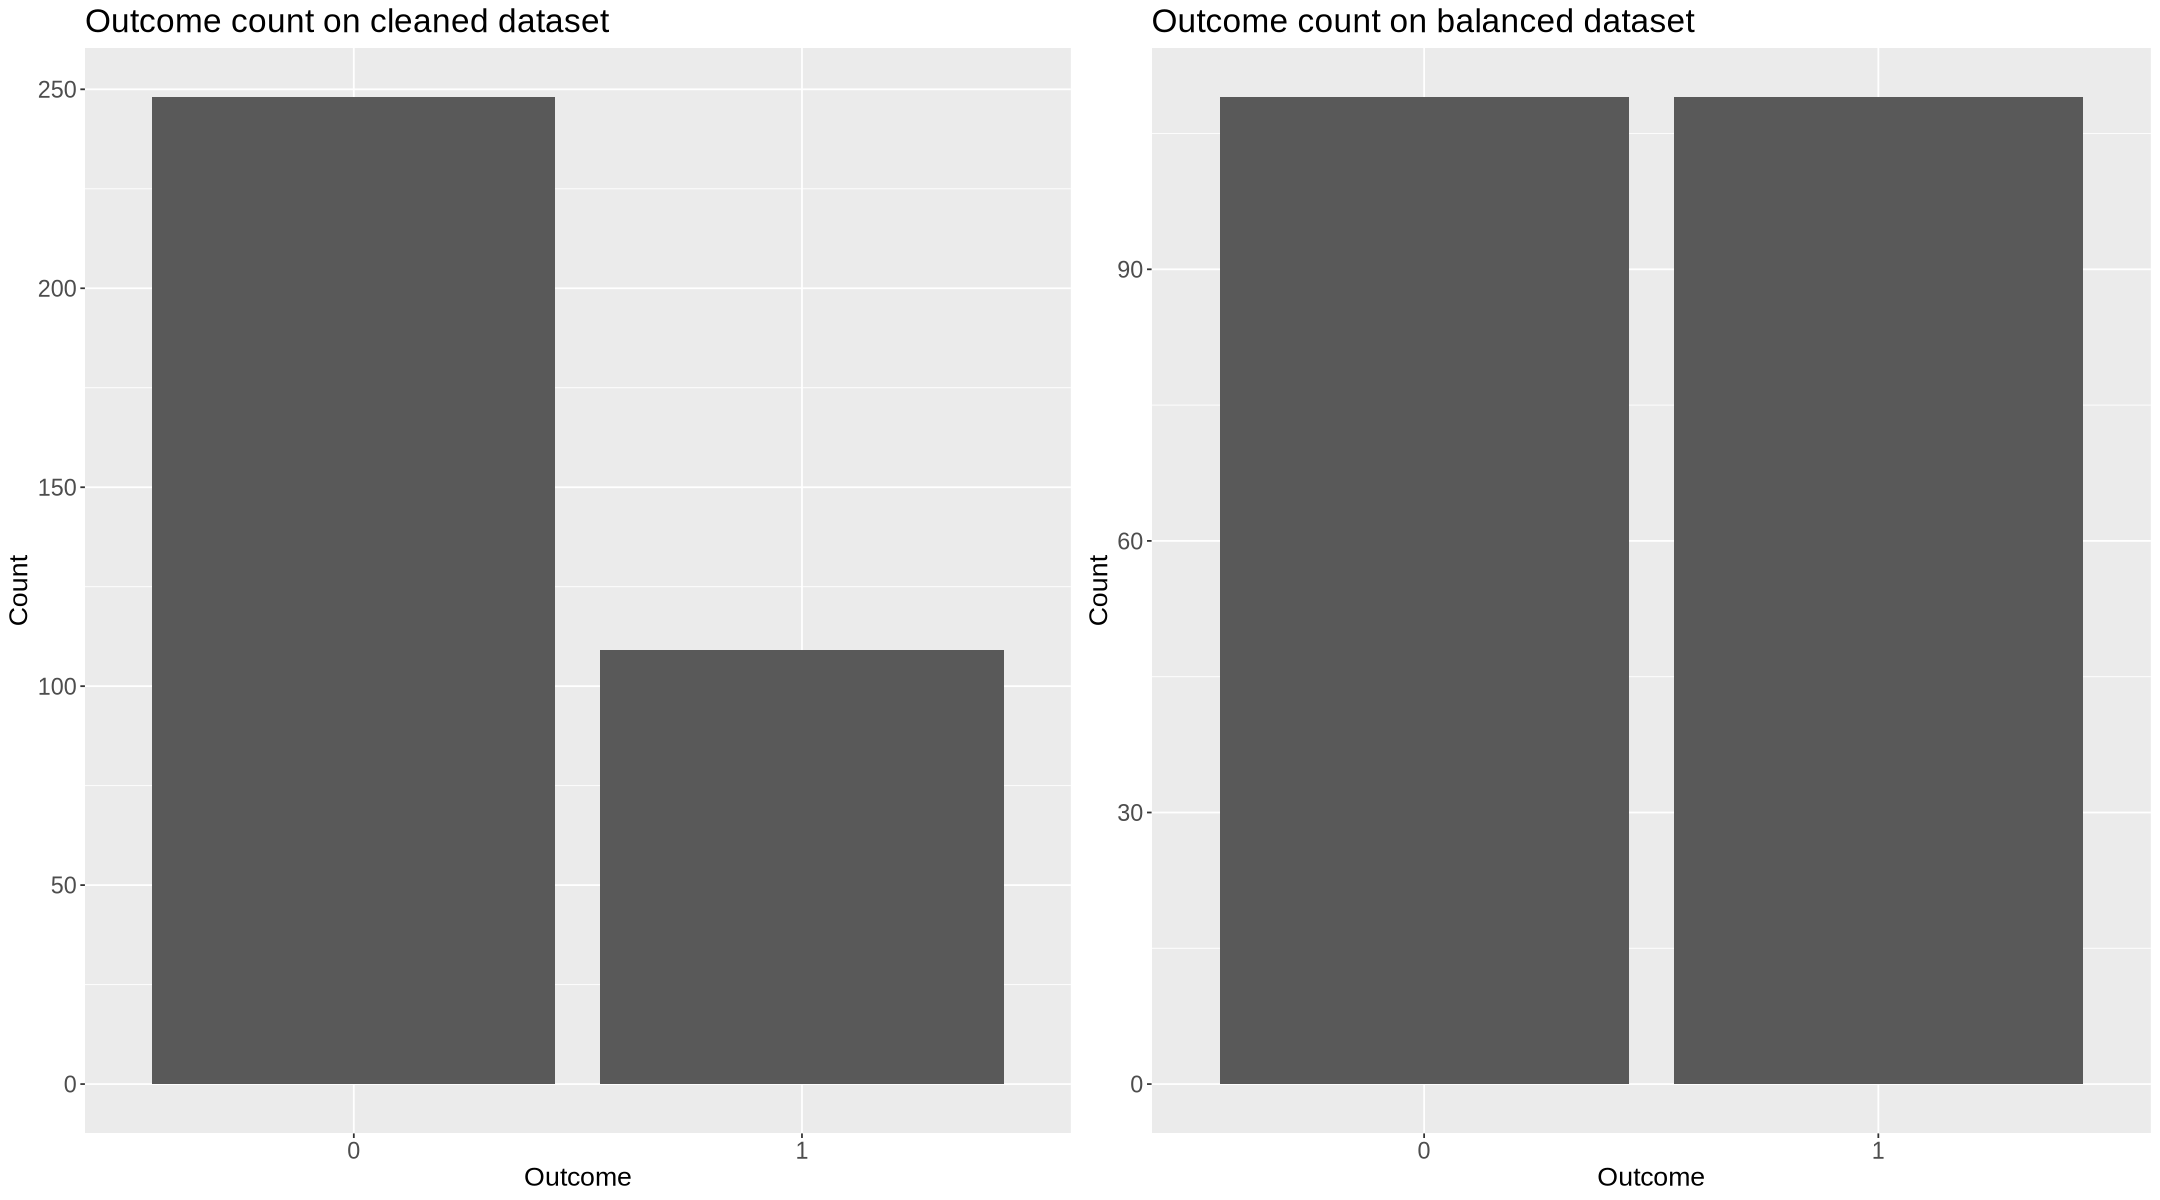

In [10]:
# Main developer: Farrel
# Contributor: Yulin (rearrange plot)

# Visualized the total number of each outcome in diabetes_clean and diabetes_balanced
options(repr.plot.width = 18, repr.plot.height = 10)

plot1 <- ggplot(diabetes_clean, aes(x = Outcome)) +
  geom_bar() +
  labs(x = "Outcome", y = "Count", title = "Outcome count on cleaned dataset")+
  theme(
    plot.title = element_text(size = 20),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text = element_text(size = 14)
  )

plot2 <- ggplot(diabetes_balanced, aes(x = Outcome)) +
  geom_bar() +
  labs(x = "Outcome", y = "Count", title = "Outcome count on balanced dataset")+
  theme(
    plot.title = element_text(size = 20),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text = element_text(size = 14)
  )

# Arrange the plots side by side
grid.arrange(plot1, plot2, ncol = 2)

Here, we decided to cut the data furthermore to balanced the data. Balancing the data would lead to reduced bias and ensure that the model weight balancly.

In [11]:
# Main developer: Yulin 
# Contributor: Farrel (Use the balanced data)

set.seed(123)

diabetes_sample <-
    diabetes_balanced %>%
    mutate(id = row_number())

training_diabetes <- 
    diabetes_sample %>%
    slice_sample(prop = 0.60)

testing_diabetes <- 
    diabetes_sample %>% 
    anti_join(training_diabetes, by = "id") %>%
    select(-id)

training_diabetes <-
    training_diabetes |>
    select(-id)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


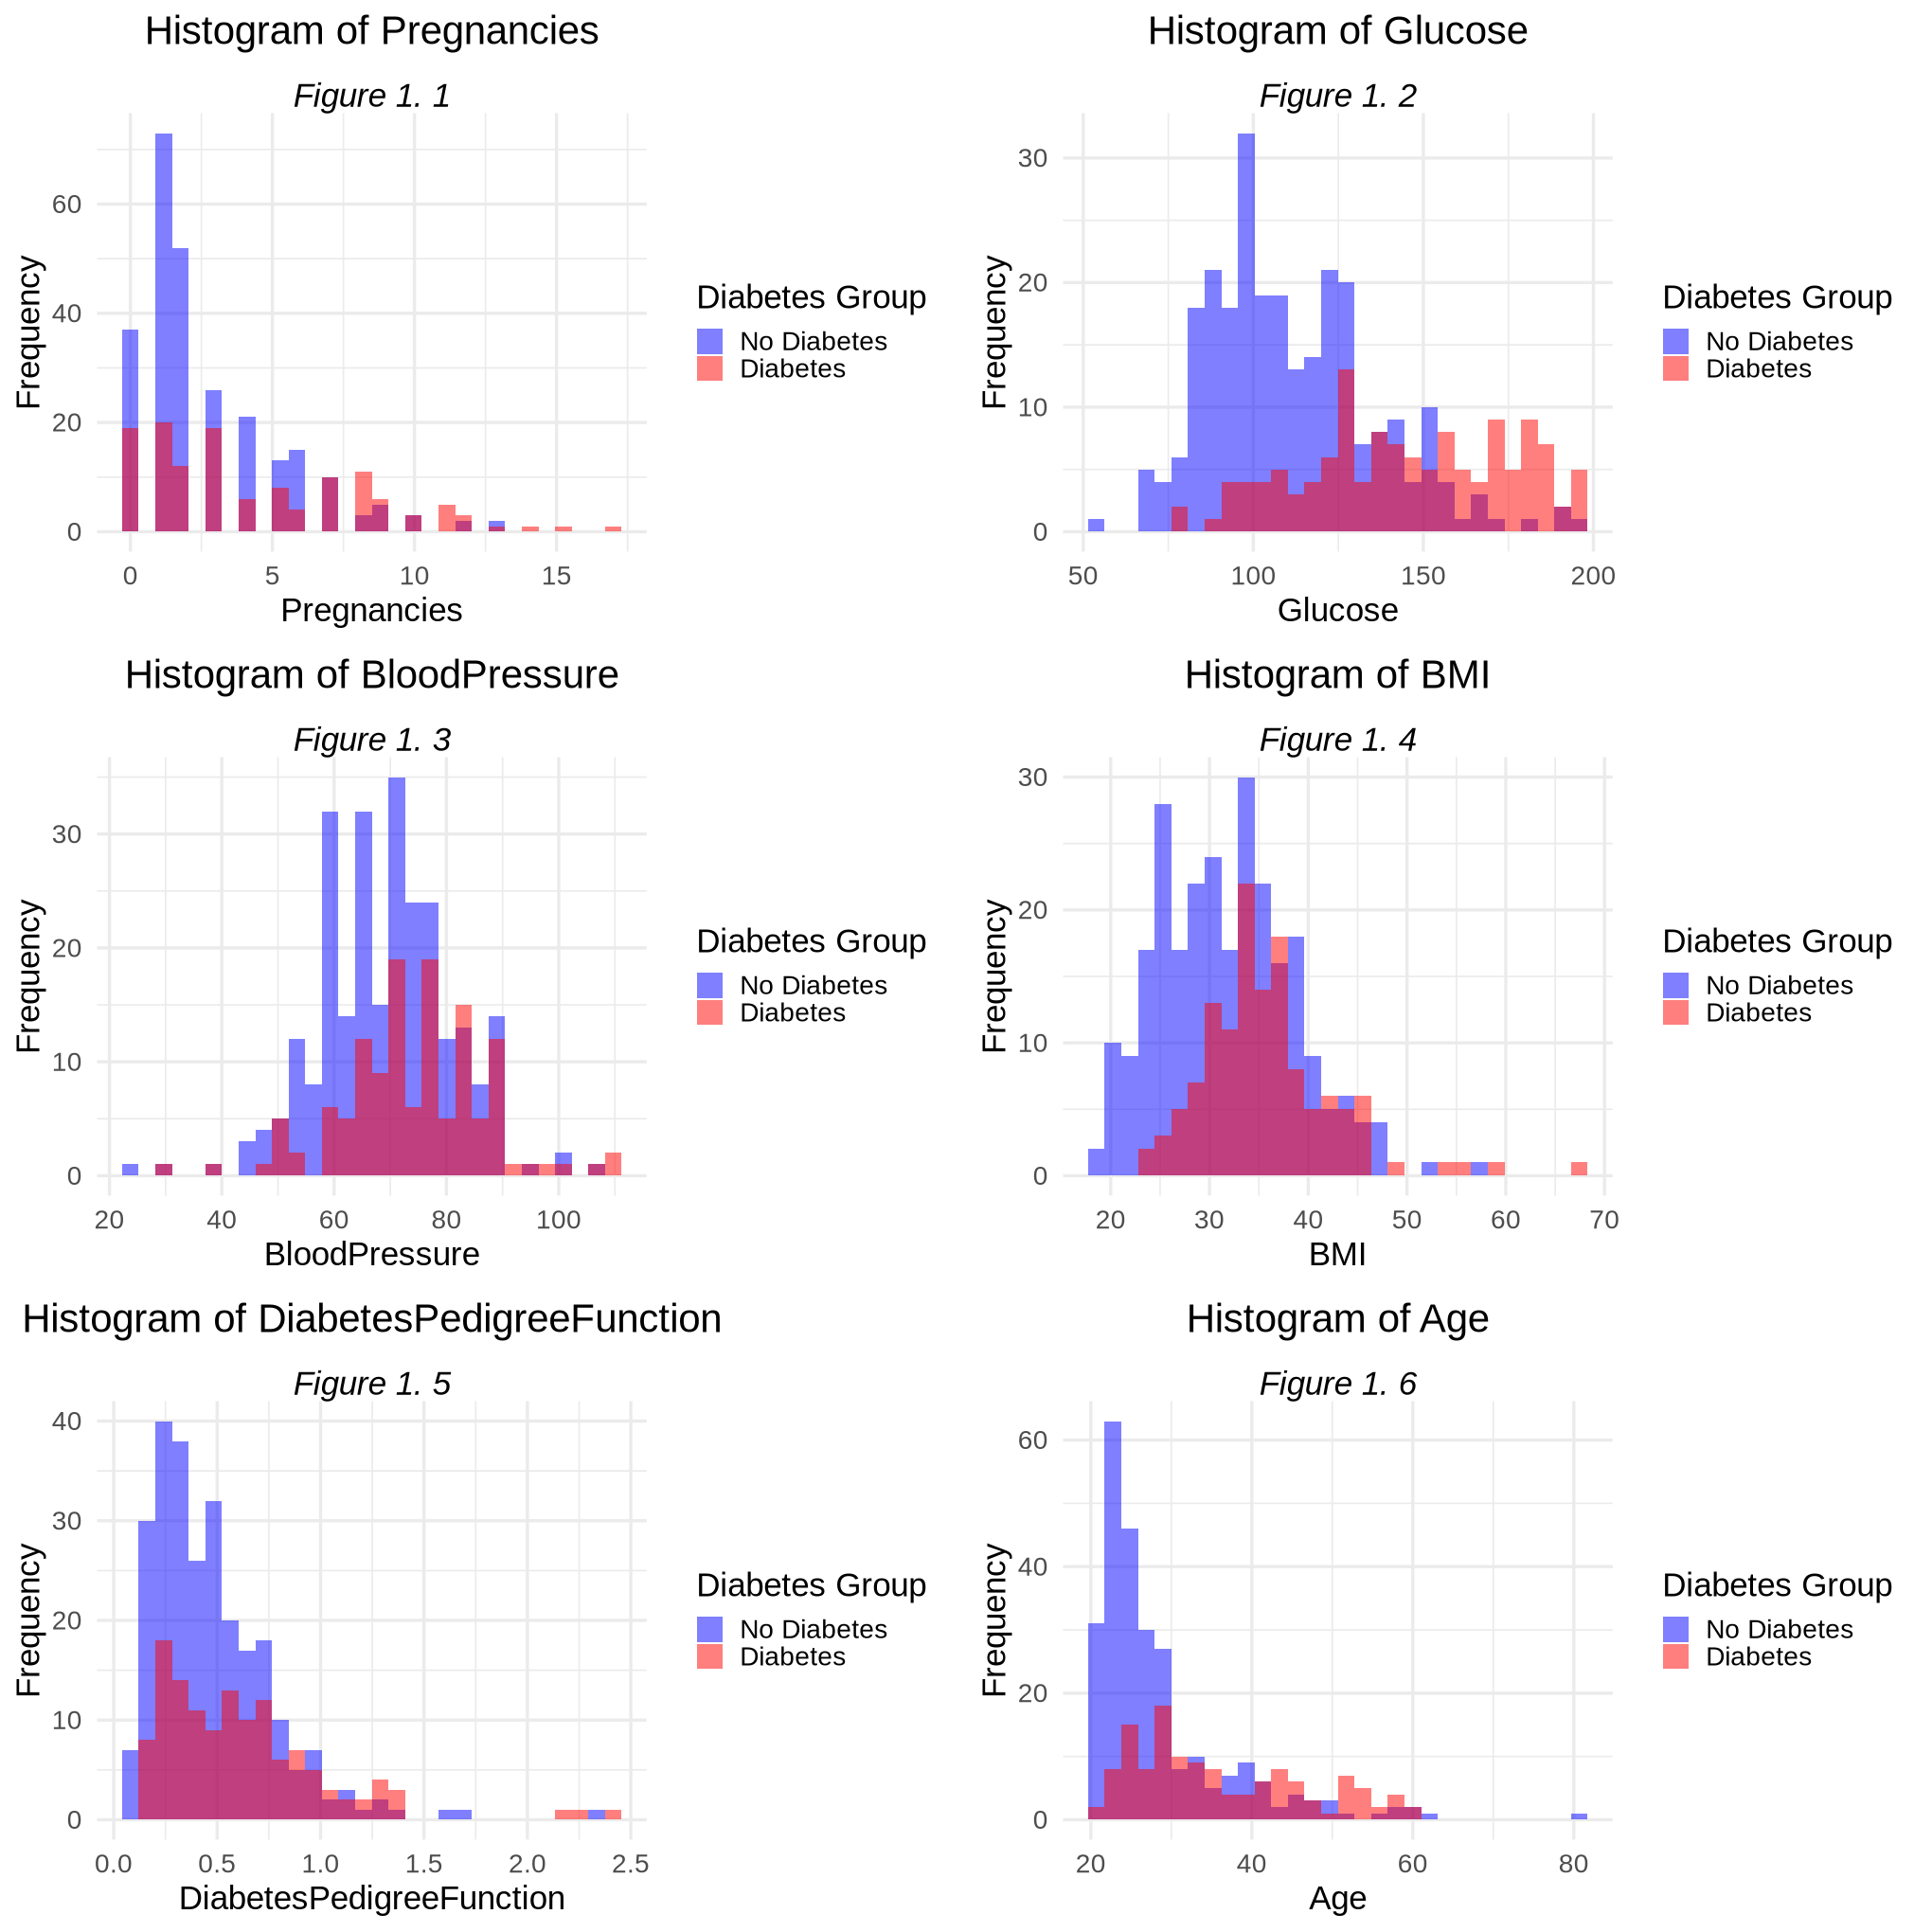

In [12]:
# Main developer: Yulin 
# Edited By Josh To add figure numbers
options(repr.plot.width = 17, repr.plot.height = 17)
numeric_cols <- c("Pregnancies", "Glucose", "BloodPressure", "BMI", "DiabetesPedigreeFunction", "Age")
my_list <- list()

for (i in seq_along(numeric_cols)) {
  feat <- numeric_cols[i]
  feat_plot <- ggplot(diabetes_cleaned) + 
    geom_histogram(aes_string(x = feat, fill = "factor(Outcome)"), bins = 30, alpha = 0.5, position = "identity") +
    labs(
      title = paste("Histogram of", feat), 
      subtitle = paste("Figure 1.", i),
      x = feat, 
      y = "Frequency"
    ) +
    scale_fill_manual(values = c("blue", "red"), labels = c("No Diabetes", "Diabetes")) +
    guides(fill = guide_legend(title = "Diabetes Group")) +
    theme_minimal(base_size = 21) + 
    theme(
      plot.title = element_text(hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5, face = "italic", margin = margin(t = 10))
    )
  my_list[[i]] <- feat_plot
}
do.call(grid.arrange,my_list)

### Preliminary Observations from Histograms

- **Pregnancies**: The distribution is right-skewed, with most values clustered around lower numbers. Patients with diabetes tend to have a higher number of pregnancies compared to those without diabetes.

- **Glucose**: There is a noticeable difference between the glucose levels of diabetic and non-diabetic patients. Diabetic patients generally have higher glucose levels, creating a clearer separation in the histogram.

- **Blood Pressure**: Both groups have similar distributions with a slight trend towards higher blood pressure in diabetic patients.

- **Skin Thickness**: Diabetic patients tend to have thicker skin measurements than non-diabetic patients.

- **Insulin**: Diabetic patients generally show a wider range of insulin values, with a tendency towards higher levels.

- **BMI**: Both groups show a right-skewed distribution, but diabetic patients tend to have higher BMI values on average compared to non-diabetic patients.

- **Diabetes Pedigree Function**: The distribution is right-skewed, with diabetic patients showing a slightly higher pedigree function, indicating a higher likelihood of diabetes based on family history.

- **Age**: The distribution is right-skewed, with a higher proportion of younger individuals. Diabetic patients tend to be older on average than non-diabetic patients.


## Modelling

In this report, we will approach the method of modelling in four sections. 
- The first step is to build the full logistic regression model by incorporating all variables.
- We then perform a backward selection to select variables with a high impact on the model and build our reduced model.
- Further modelling methods then include Lasso and Ridge regression. 


We then compared the result of our model using the testing dataset to find the accuracy, sensitivity, auc performance values, and specificity of a logistic regression model based on our training data.


### Default Logistic Regression

We will now start by making a generalized linear model using all variables as predictor variables.

In [13]:
# Main developer: Farrel
# Contributor: Yulin (rearrange plot)

options(repr.plot.width = 11, repr.plot.height = 11)
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)
# Fit the full model to Logistic Regression
full_diabetes_model <- glm(Outcome ~ .,
                            data = training_diabetes,
                            family = "binomial")

ROC_full_log <-
    roc(response = testing_diabetes$Outcome,
        predictor = predict(full_diabetes_model, type = "response", newdata=testing_diabetes))

diabetes_AUC_models <- 
    tibble(
        model = "ordinary",
        auc = as.numeric(ROC_full_log$auc))

summary(full_diabetes_model)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
glm(formula = Outcome ~ ., family = "binomial", data = training_diabetes)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.473e+01  2.916e+00  -5.049 4.44e-07 ***
Pregnancies               2.047e-01  1.068e-01   1.916 0.055428 .  
Glucose                   4.550e-02  1.130e-02   4.027 5.66e-05 ***
BloodPressure             3.717e-02  2.705e-02   1.374 0.169323    
SkinThickness            -7.457e-03  3.258e-02  -0.229 0.818928    
Insulin                  -2.317e-04  3.826e-03  -0.061 0.951714    
BMI                       1.161e-01  6.015e-02   1.929 0.053672 .  
DiabetesPedigreeFunction  3.023e+00  8.576e-01   3.525 0.000424 ***
Age                       1.321e-02  3.548e-02   0.372 0.709769    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 180.22  on 129  degrees of freedom
Residual deviance: 105.11  on 121  degrees o

### Backward Selection Logistic Regression

The feature selection process was done manually in building the reduced model using backward selection and automatically in Ridge and Lasso. The feature selection in the backward selection was done by removing the predictor variable, which reduced AIC until there was no statistical significance to remove the remaining variables. This process was done semi-automatically using R ```regsubsets``` function.

In [14]:
# Main developer: Farrel

# Backward selection process
bwd_sel <- regsubsets(Outcome ~ ., data = training_diabetes, method = "backward", nvmax = 8)
summary_bwd <- summary(bwd_sel)


# extract the logical row for the model with the minimum Cp
selected_preds_bwd <- summary_bwd$which[which.min(summary_bwd$cp), ]

# filter out the intercept, keep only true values (selected predictors)
selected_preds_bwd <- names(selected_preds_bwd[selected_preds_bwd == TRUE])

# remove Intercept from the list of selected predictors
selected_preds_bwd <- selected_preds_bwd[selected_preds_bwd != "(Intercept)"]
selected_preds_bwd

[1] "Pregnancies"              "Glucose"                 
[3] "BloodPressure"            "BMI"                     
[5] "DiabetesPedigreeFunction"

From previous result of backward selection process, we have found that the model selected should consist of 'Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction'. We will now fit a GLM to have only these predictor variables.

In [15]:
# Main developer: Farrel
# Contributor: Yulin (rearrange plot)


options(repr.plot.width = 11, repr.plot.height = 11)
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)
# Fit the full model to Logistic Regression
reduced_diabetes_model <- glm(Outcome ~ Pregnancies + Glucose + BloodPressure + BMI + DiabetesPedigreeFunction,
                            data = training_diabetes,
                            family = "binomial")

ROC_reduced_log <-
    roc(response = testing_diabetes$Outcome,
        predictor = predict(reduced_diabetes_model, type = "response", newdata=testing_diabetes))

diabetes_AUC_models <- diabetes_AUC_models |>
    add_row(model = "reduced", auc = as.numeric(ROC_reduced_log$auc))

summary(reduced_diabetes_model)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
glm(formula = Outcome ~ Pregnancies + Glucose + BloodPressure + 
    BMI + DiabetesPedigreeFunction, family = "binomial", data = training_diabetes)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -14.54040    2.85423  -5.094 3.50e-07 ***
Pregnancies                0.22827    0.07900   2.890 0.003858 ** 
Glucose                    0.04586    0.01010   4.542 5.57e-06 ***
BloodPressure              0.04006    0.02612   1.534 0.125044    
BMI                        0.10600    0.04567   2.321 0.020291 *  
DiabetesPedigreeFunction   2.99618    0.84915   3.528 0.000418 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 180.22  on 129  degrees of freedom
Residual deviance: 105.28  on 124  degrees of freedom
AIC: 117.28

Number of Fisher Scoring iterations: 5


Now, we will created testing and training matricies in order to start LASSO and RIDGE regression

In [16]:
# Main developer: Yulin 

set.seed(123)

diabetes_X_train <- model.matrix(object = Outcome ~ .,
  data = training_diabetes)[, -1]

diabetes_Y_train <- as.matrix(training_diabetes[, "Outcome"])

diabetes_X_test <- model.matrix(object = Outcome ~ .,
  data = testing_diabetes)[, -1]

diabetes_Y_test <- as.matrix(testing_diabetes[, "Outcome"])

### Ridge Regression

Now we will perfrom Ridge regression using ```cv.glmnet```. First, we use crossfold validation to determine the best $\lambda$ value for our model, using auc as our goodness of fit metric.

In [17]:
# Main developer: Yulin 

set.seed(123)

diabetes_cv_lambda_ridge <- 
    cv.glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        type.measure = "auc",
        nfolds = 10)

diabetes_cv_lambda_ridge


Call:  cv.glmnet(x = diabetes_X_train, y = diabetes_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure      SE Nonzero
min   0.18    79  0.8556 0.04109       8
1se 236.84     2  0.8371 0.04363       8

Now, we will fit two models based on the $\lambda$ value that gives the best average auc over the all of the folds, and a $\lambda$ value that is within one standard error of that maximum

In [18]:
# Main developer: Yulin 

diabetes_cv_lambda_max_AUC_ridge <- round(diabetes_cv_lambda_ridge$lambda.min, 4)
diabetes_cv_lambda_1se_AUC_ridge <- round(diabetes_cv_lambda_ridge$lambda.1se, 4)

print(paste("The lambda_min in Ridge Regression:", diabetes_cv_lambda_max_AUC_ridge))
print(paste("The lambda_1se in Ridge Regression:", diabetes_cv_lambda_1se_AUC_ridge))

[1] "The lambda_min in Ridge Regression: 0.1834"
[1] "The lambda_1se in Ridge Regression: 236.8353"


In [19]:
# Main developer: Yulin 

set.seed(123)

diabetes_ridge_max_AUC <- 
    glmnet(
        x = diabetes_X_train, y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        lambda = diabetes_cv_lambda_max_AUC_ridge)

diabetes_ridge_1se_AUC <- 
    glmnet(
        x = diabetes_X_train, y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        lambda = diabetes_cv_lambda_1se_AUC_ridge)

coef(diabetes_ridge_max_AUC)
coef(diabetes_ridge_1se_AUC)

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              -6.515762927
Pregnancies               0.074775335
Glucose                   0.015912865
BloodPressure             0.019101698
SkinThickness             0.009797066
Insulin                   0.002389522
BMI                       0.031795167
DiabetesPedigreeFunction  1.020668650
Age                       0.019511492

9 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)              -1.792051e-02
Pregnancies               2.059604e-04
Glucose                   3.509578e-05
BloodPressure             5.241048e-05
SkinThickness             5.043807e-05
Insulin                   9.272995e-06
BMI                       8.760064e-05
DiabetesPedigreeFunction  1.794555e-03
Age                       6.989951e-05

In [28]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    diabetes_AUC_models %>% 
    add_row(model = "ridge_lambda_min", auc = diabetes_cv_lambda_ridge$cvm[diabetes_cv_lambda_ridge$index[1]]) |>
    add_row(model = "ridge_lambda_1se", auc = diabetes_cv_lambda_ridge$cvm[diabetes_cv_lambda_ridge$index["1se",]])

We have now fitted 2 ridge regression models, and will now perform the same methods, but this time using lasso regression.

### Lasso Regression

In [29]:
# Main developer: Yulin 

set.seed(123)

diabetes_cv_lambda_LASSO <- cv.glmnet(
    x = diabetes_X_train, y = diabetes_Y_train,
    alpha = 1,
    family = "binomial",
    type.measure = "auc",
    nfolds = 10
)

diabetes_cv_lambda_LASSO


Call:  cv.glmnet(x = diabetes_X_train, y = diabetes_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.03684    22  0.8513 0.04237       6
1se 0.08511    13  0.8158 0.03565       6

In [30]:
# Main developer: Yulin 

diabetes_cv_lambda_max_AUC_LASSO <- round(diabetes_cv_lambda_LASSO$lambda.min, 4)
diabetes_cv_lambda_1se_AUC_LASSO <- round(diabetes_cv_lambda_LASSO$lambda.1se, 4)

print(paste("The lambda_min in LASSO Regression:", diabetes_cv_lambda_max_AUC_LASSO))
print(paste("The lambda_1se in LASSO Regression:", diabetes_cv_lambda_1se_AUC_LASSO))

[1] "The lambda_min in LASSO Regression: 0.0368"
[1] "The lambda_1se in LASSO Regression: 0.0851"


In [31]:
# Main developer: Yulin 

set.seed(123)

diabetes_LASSO_max_AUC <- 
    glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 1,
        family = "binomial",
        lambda = diabetes_cv_lambda_max_AUC_LASSO)

diabetes_LASSO_1se_AUC <- 
    glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 1,
        family = "binomial",
        lambda = diabetes_cv_lambda_1se_AUC_LASSO)

coef(diabetes_LASSO_max_AUC)
coef(diabetes_LASSO_1se_AUC)

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              -8.436701085
Pregnancies               0.116586821
Glucose                   0.030970565
BloodPressure             0.018777945
SkinThickness             .          
Insulin                   .          
BMI                       0.050165014
DiabetesPedigreeFunction  1.620920904
Age                       0.007509197

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              -4.275901012
Pregnancies               0.056911827
Glucose                   0.022678883
BloodPressure             0.004408736
SkinThickness             .          
Insulin                   .          
BMI                       0.012782684
DiabetesPedigreeFunction  0.706258492
Age                       0.002566760

In [32]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    diabetes_AUC_models %>% 
    add_row(model = "lasso_lambda_min", auc = diabetes_cv_lambda_LASSO$cvm[diabetes_cv_lambda_LASSO$index[1]]) |>
    add_row(model = "lasso_lambda_1se", auc = diabetes_cv_lambda_LASSO$cvm[diabetes_cv_lambda_LASSO$index["1se",]])

diabetes_AUC_models

model,auc
<chr>,<dbl>
ordinary,0.8412698
reduced,0.8390023
lasso_lambda_min,0.8513095
lasso_lambda_1se,0.8157937
ridge_lambda_min,0.8555952
ridge_lambda_1se,0.8371032
lasso_lambda_min,0.8513095
lasso_lambda_1se,0.8157937


Now, We will take a look at what is happening with our lambda values over our cross fold validation for both ridge and lasso.

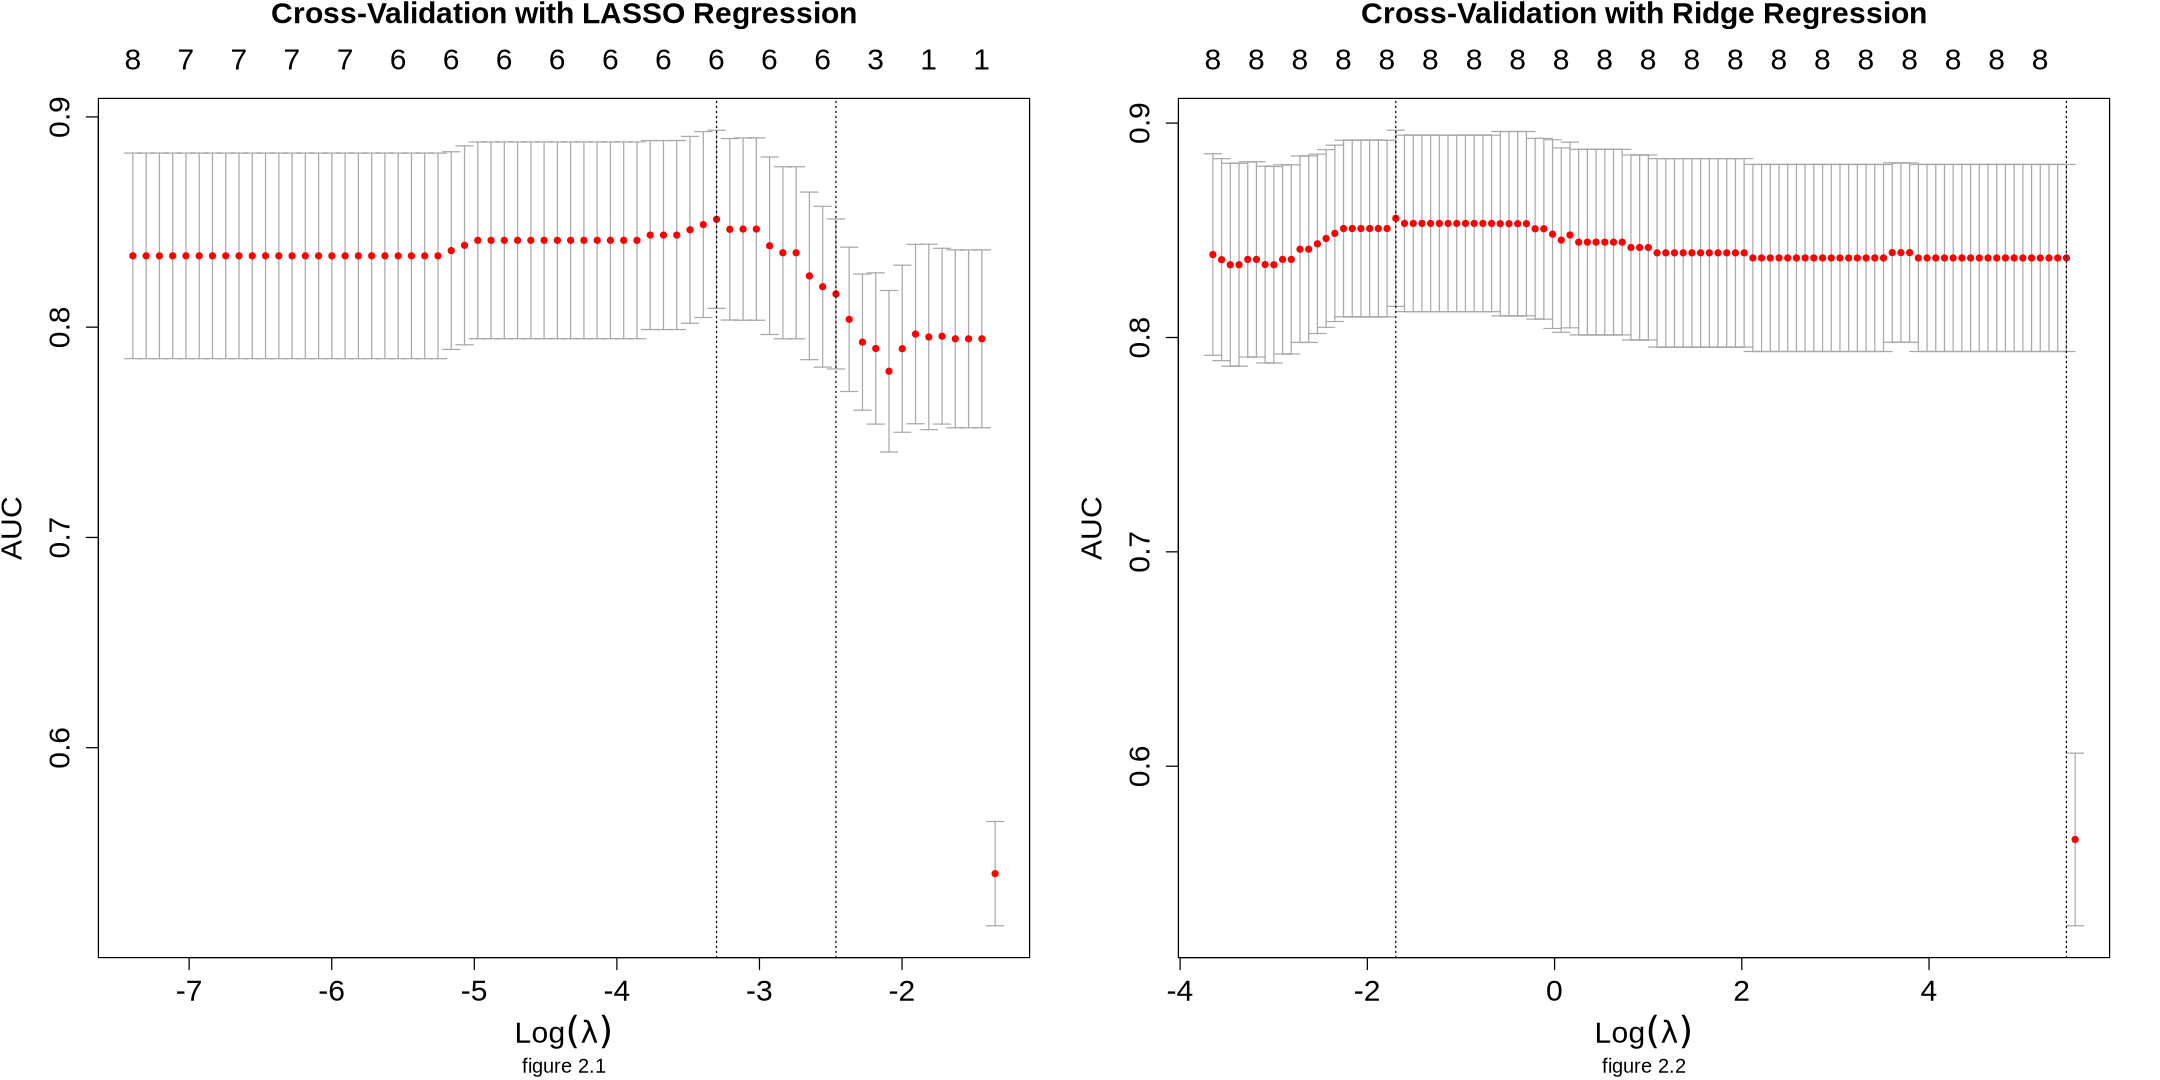

In [33]:
# Main developer: Josh
# Contributor: Yulin (rearrange plot)

options(repr.plot.width = 18, repr.plot.height = 9)
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)
par(mfrow = c(1, 2))


plot(diabetes_cv_lambda_LASSO, 
     main = "Cross-Validation with LASSO Regression\n\n",
    sub = "figure 2.1")


plot(diabetes_cv_lambda_ridge, 
     main = "Cross-Validation with Ridge Regression\n\n",
    sub = "figure 2.2")


Now, we have fitted all of our models, we will begin the comparison with the methods we have described in our plan.

In [34]:
# Main developer: Yulin 
# Contributor: Farrel (Add ROC for full model and reduced model)

ROC_lasso_lambda_min <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_LASSO_max_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_lasso_lambda_1se <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_LASSO_1se_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ridge_lambda_min <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_ridge_max_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ridge_lambda_1se <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_ridge_1se_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ordinary <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(full_diabetes_model,
                      newdata = testing_diabetes))

ROC_reduced <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(reduced_diabetes_model,
                      newdata = testing_diabetes))

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



The cross-validation shows that Lasso generally achieves a higher AUC at λ min, so it seems better suited to this dataset than Ridge. However, Lasso shows higher variability, whereas Ridge is more stable.

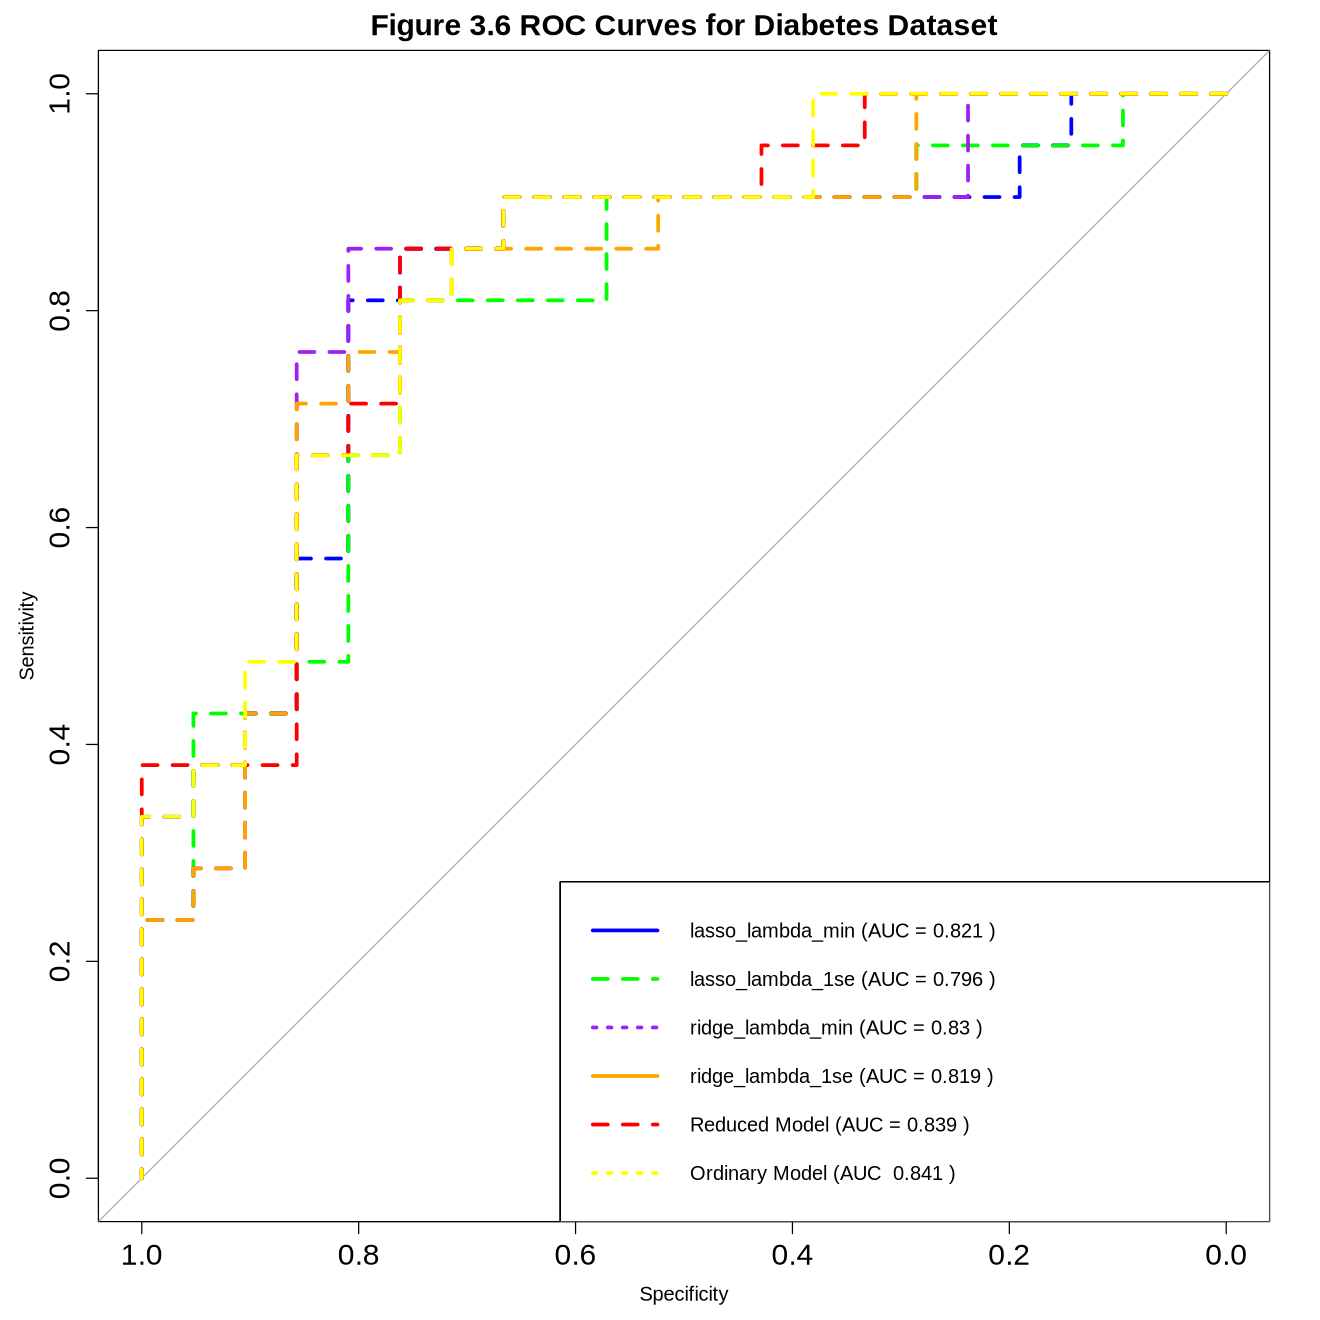

In [35]:
#Main author: Josh and Yulin
# Contributor: Farrel (Add the ordinary and reduced ROC graph)

#Roc Auc Graphs
roc_models <- list(
    lasso_lambda_min = ROC_lasso_lambda_min,
    lasso_lambda_1se = ROC_lasso_lambda_1se,
    ridge_lambda_min = ROC_ridge_lambda_min,
    ridge_lambda_1se = ROC_ridge_lambda_1se,
    ordinary = ROC_ordinary,
    reduced = ROC_reduced
)

colors <- c(
    lasso_lambda_min = "blue",
    lasso_lambda_1se = "green",
    ridge_lambda_min = "purple",
    ridge_lambda_1se = "orange",
    ordinary = "red",
    reduced = "yellow"
)

legends <- c(
    lasso_lambda_min = "Lasso (lambda.min)",
    lasso_lambda_1se = "Lasso (lambda.1se)",
    ridge_lambda_min = "Ridge (lambda.min)",
    ridge_lambda_1se = "Ridge (lambda.1se)",
    ordinary = "Ordinary",
    reduced = "Reduced"
)

options(repr.plot.width = 11, repr.plot.height = 11)
par(cex = 1, cex.lab = 1, cex.axis = 1.5, cex.main = 1.5)

#for loop for each model and to add figure numbers

#plotting all of the roc's in one graph

plot(
  roc_models[[1]],
  col = colors[1],
  lwd = 3,
  lty = 2,
  main = "Figure 3.6 ROC Curves for Diabetes Dataset",
  legacy.axes = FALSE
)
for (i in 2:length(roc_models)) {
  plot(
    roc_models[[i]],
    col = colors[i],
    lwd = 3,
    lty = 2,
    add = TRUE
  )
legend("bottomright",
       legend = c(
    paste("lasso_lambda_min (AUC =", round(ROC_lasso_lambda_min$auc, 3), ")"),
    paste("lasso_lambda_1se (AUC =", round(ROC_lasso_lambda_1se$auc, 3), ")"),
    paste("ridge_lambda_min (AUC =", round(ROC_ridge_lambda_min$auc, 3), ")"),
    paste("ridge_lambda_1se (AUC =", round(ROC_ridge_lambda_1se$auc, 3), ")"),
    paste("Reduced Model (AUC =", round(ROC_reduced$auc, 3), ")"),
    paste("Ordinary Model (AUC ", round(ROC_ordinary$auc, 3), ")")),
       col = colors, 
       lwd = 3, lty = c(1, 2, 3))
    
}


This graph compares the ROC and AUC for each of our models. The highest AUC, and hence the best model, is the ``ordinary model`` with 0.841, followed by the ``reduced model`` with 0.839. The worst is ``lasso_lamda_1se``, with 0.796. Additionally, the lasso and ridge models with minimum lambda and ridge perform better than 1se lambda and ridge. 


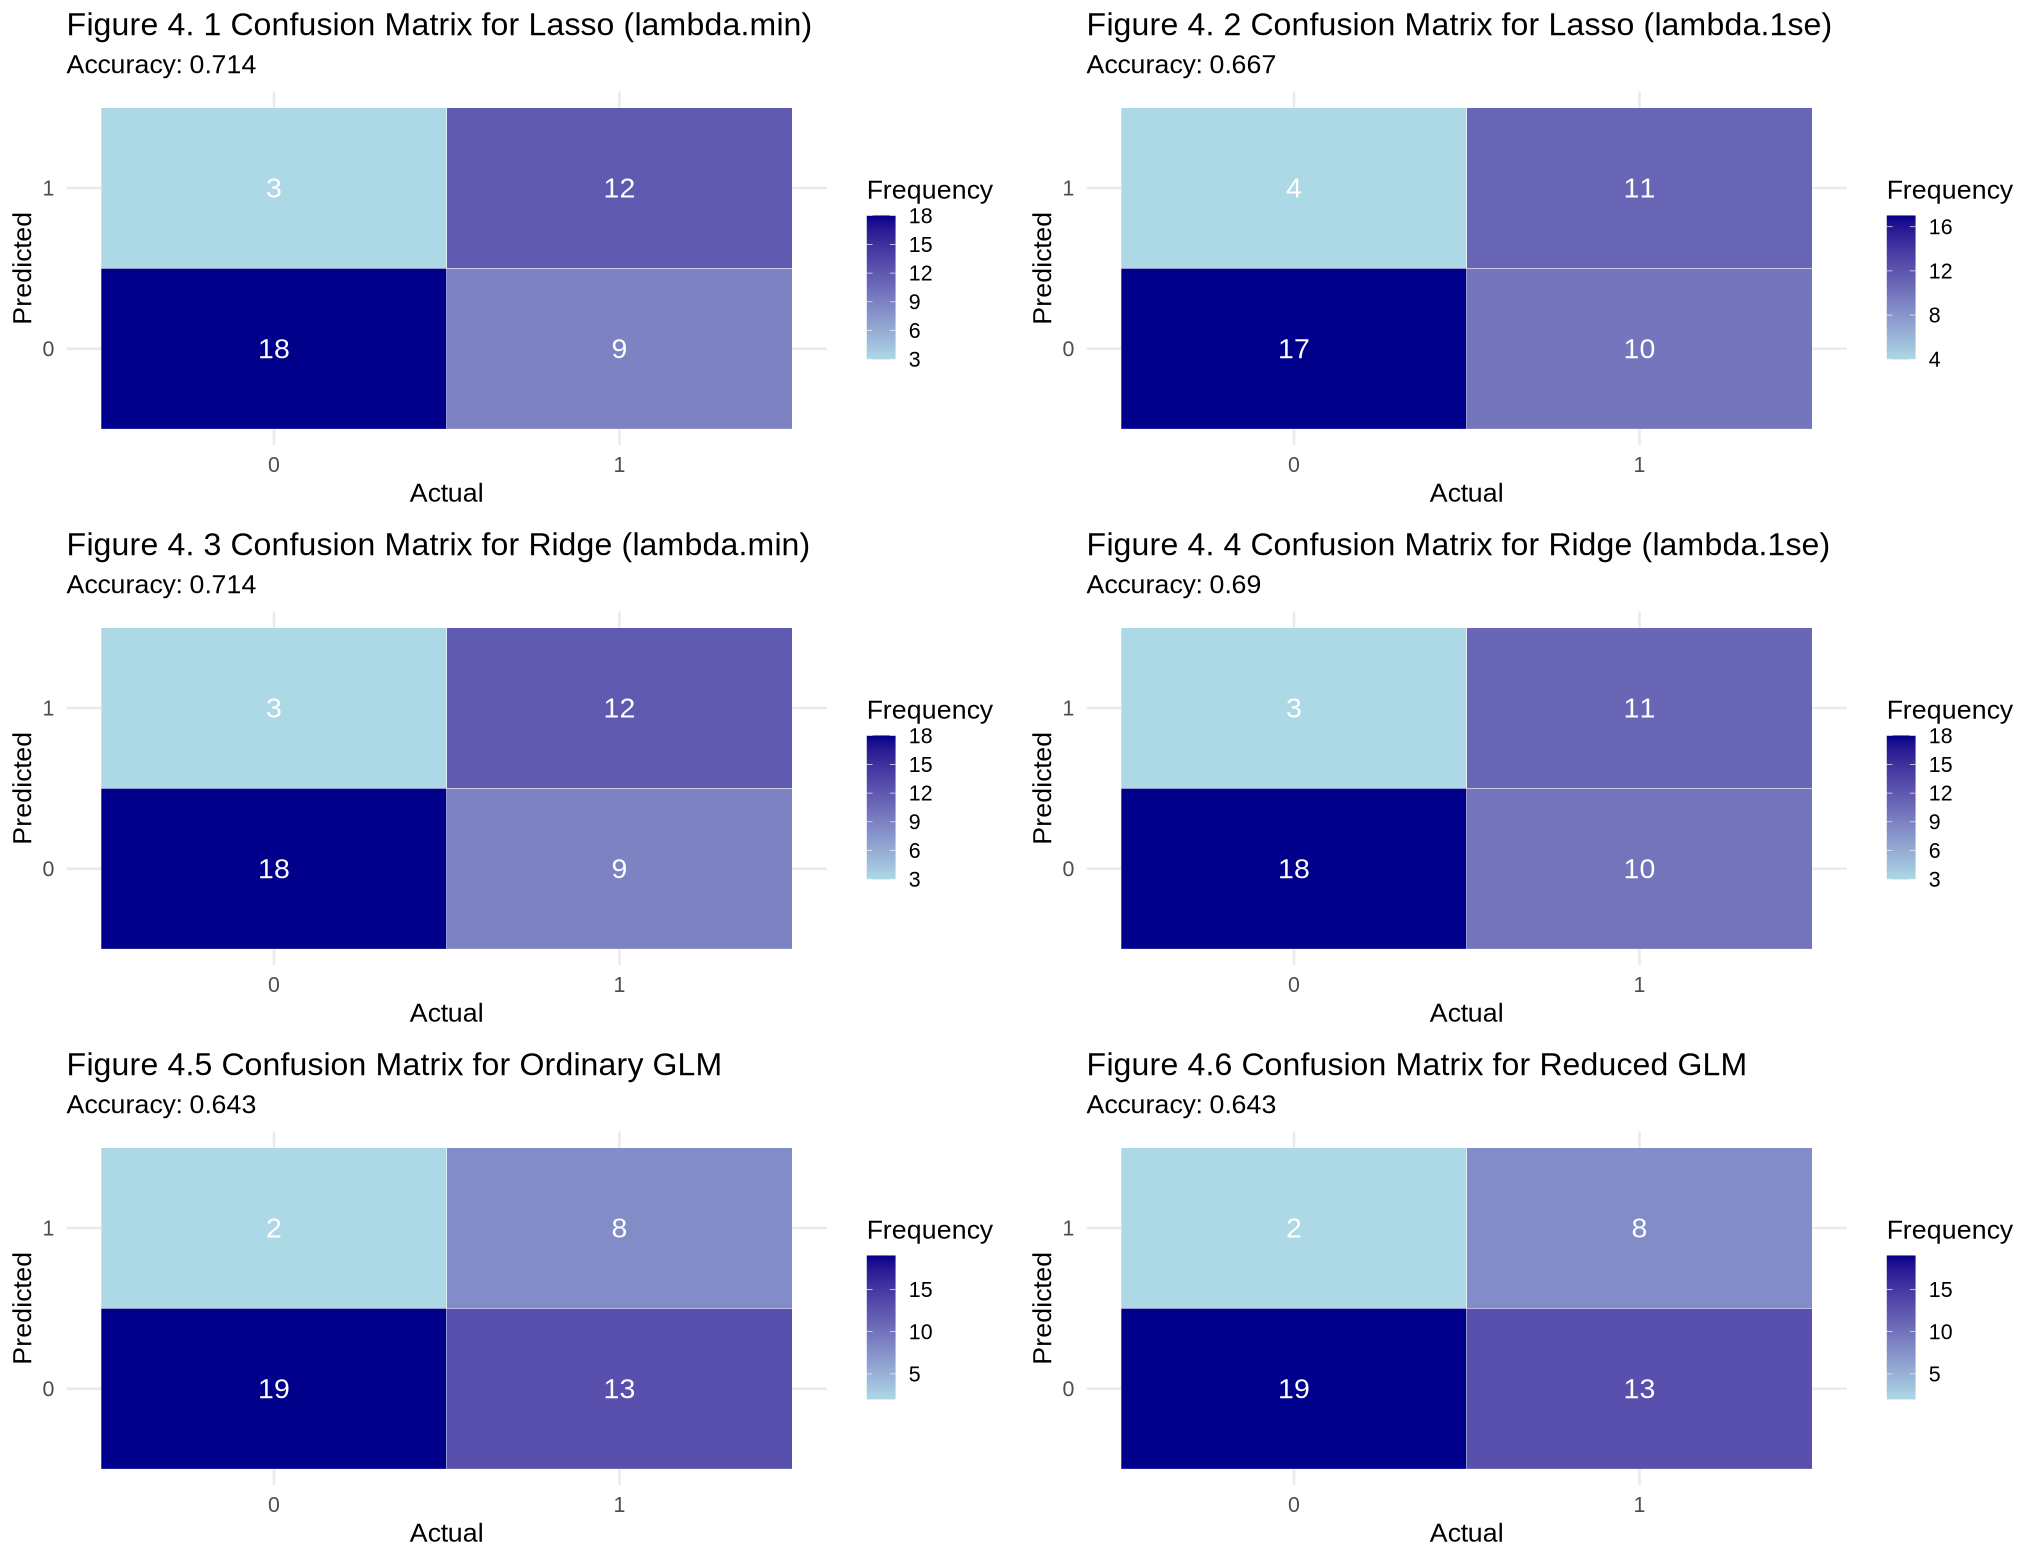

In [36]:
#Main Author : Josh
# Contributor: Farrel (Add reduced model confusion matrix)
#Making confusion matricies and testing accuracy for models
models <- list(
  diabetes_LASSO_max_AUC,
  diabetes_LASSO_1se_AUC,
  diabetes_ridge_max_AUC,
  diabetes_ridge_1se_AUC

)

model_names <- c(
  "Lasso (lambda.min)",
  "Lasso (lambda.1se)",
  "Ridge (lambda.min)",
  "Ridge (lambda.1se)"

)
plts <- list()
p_val <- 0.5
#for al lasso and ridge models
options(repr.plot.width = 17, repr.plot.height = 13)
for (i in seq_along(models)) {
  model <- models[[i]]
  model_name <- model_names[i]
  
  predicted_vals <- predict(model, newx = diabetes_X_test, type = "response")
  fitted_values <- ifelse(predicted_vals > p_val, 1, 0)
  accuracy <- mean(fitted_values == testing_diabetes$Outcome)

  confusion_m <- table(
    Predicted = factor(fitted_values, levels = c(0, 1)),
    Actual = factor(testing_diabetes$Outcome, levels = c(0, 1))
  )

  confusion_m_df <- as.data.frame(confusion_m)
  colnames(confusion_m_df) <- c("Predicted", "Actual", "Frequency")
  
  plot <- ggplot(confusion_m_df, aes(x = Actual, y = Predicted, fill = Frequency)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Frequency), color = "white", size = 6) +
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
      title = paste("Figure 4.",i,"Confusion Matrix for", model_name),
      subtitle = paste("Accuracy:", round(accuracy, 3)),  
      x = "Actual",
      y = "Predicted"
    ) +
    theme_minimal(base_size = 16)
    plts[[i]] <- plot
  
}



#ordinary glm matrix
predicted <- predict(full_diabetes_model,newdata = testing_diabetes)
  fitted <- ifelse(predicted > p_val, 1, 0)
  accuracy <- mean(fitted == testing_diabetes$Outcome)
  confusion_m <- table(
    Predicted = factor(fitted, levels = c(0, 1)),
    Actual = factor(testing_diabetes$Outcome, levels = c(0, 1))
  )

  confusion_m_df <- as.data.frame(confusion_m)
  colnames(confusion_m_df) <- c("Predicted", "Actual", "Frequency")
  glm_plt <- ggplot(confusion_m_df, aes(x = Actual, y = Predicted, fill = Frequency)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Frequency), color = "white", size = 6) +
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
      title = paste("Figure 4.5 Confusion Matrix for Ordinary GLM"),
      subtitle = paste("Accuracy:", round(accuracy, 3)),  
      x = "Actual",
      y = "Predicted"
    ) +
    theme_minimal(base_size = 16)
    plts[[5]] <- glm_plt

#reduced glm matrix
predicted <- predict(reduced_diabetes_model,newdata = testing_diabetes)
  fitted <- ifelse(predicted > p_val, 1, 0)
  accuracy <- mean(fitted == testing_diabetes$Outcome)
  confusion_m <- table(
    Predicted = factor(fitted, levels = c(0, 1)),
    Actual = factor(testing_diabetes$Outcome, levels = c(0, 1))
  )

  confusion_m_df <- as.data.frame(confusion_m)
  colnames(confusion_m_df) <- c("Predicted", "Actual", "Frequency")
  glm_plt <- ggplot(confusion_m_df, aes(x = Actual, y = Predicted, fill = Frequency)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Frequency), color = "white", size = 6) +
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
      title = paste("Figure 4.6 Confusion Matrix for Reduced GLM"),
      subtitle = paste("Accuracy:", round(accuracy, 3)),  
      x = "Actual",
      y = "Predicted"
    ) +
    theme_minimal(base_size = 16)
    plts[[6]] <- glm_plt

do.call(grid.arrange,plts)

The confusion matrices in Figures 4.1-6 show the performance of each model, which all appear to be similar, but Lasso has the highest accuracy. However, as the dataset is small, it may not be as reliable.


# Discussion

### Summarize what you found and the implications/impact of your findings.


Based on the ROC curve analysis, we found that the ``ordinary model`` performed best with an AUC of 0.841. However, we selected the ``reduced model`` as the final model. Although it has the second-highest AUC of 0.839, this value is only marginally lower (by 0.002) than the AUC of the ``ordinary model``, 0.841. This negligible difference is considered insignificant. Opting for the ``reduced model`` offers the advantage of using fewer features, which reduces the complexity and computational cost of fitting the model while maintaining nearly equivalent predictive performance. From figure ```figure 3.6``` we see that the roc curves for all of the models are similarly distributed and have roughly a similar shape. From this, we can obtain that there is little difference between the models sensitivity and specificity, and which means we are safe
to choose the model with the highest AUC value and have little drawback.


Based on the confusion matrices in figures 4.1-4.5, the Lasso and Ridge regression models with the minimum lambda value had the best test sample prediction rate, 0.714. However, this metric for evaluating the models is not ideal, as the amount of test data observations is low, so minor errors will significantly impact the accuracy percentage. For this accuracy test, we set the p-value threshold to 0.5, which could have biased the models toward predicting diabetes, as there is a higher percentage of non-diabetics in our data set, which might further skew a small test data set. Since the ``ordinary model`` and ``reduced model`` had the highest AUC values, even though they had poor accuracy in our test data, we can still expect them to perform well outside of this testing data.


### If relevant, discuss whether your results were what you expected to find.


We expected the full model to have a higher AUC than other models (reduced, lasso, and ridge) since it weights every explanatory variable, and we indeed found that the full model performs better than the rest of the models. We also expected that different types of models have slight differences in AUC compared to the full model, and we observed those as well. This expectation arises from the method of modelling itself since the reduced, lasso, and ridge all have the same properties, such that, for better representation of the data and simplicity of the data, we can cut corners (variable with less effect). In theory, this would lead to an insignificant drop in model performance, and we found that the drop in performance in our dataset and modelling is not significant.


We also expected that Lasso would perform the second best. However, we found that the reduced model using backward selection performs better. This may be because Lasso would reduce the unnecessary weight of an explanatory variable near 0, but not exactly 0, which could lead to more noise or uncertainty in the data, while backward selection entirely ignores that unnecessary variable. However, doing backward selection took longer computing time than using Lasso, which might indicate that for larger datasets, it is much more feasible to do Lasso instead of backward selection.


### Discuss how your model could be improved;


Our model could be improved by adding additional data such that the training and testing data could be enlarged. Further data completion, such as the imputer, could also be possible since we found that we omitted more than 400 rows of data due to missing values. If the missing values were available, it would be beneficial for the modelling. Increasing the dataset would lead to more accurate and representative model results. Furthermore, balancing the dataset can lead to the loss of valuable data points. To address this, we could consider using class weights during model training. This approach allows us to retain more data points for cross-validation and testing, ensuring a more comprehensive evaluation of the model’s performance.


### Discuss future questions/research this study could lead to.


This project can lead to future research questions such as:
- How does the accuracy differ between different age groups and genders of Pima Indians?
- How do the predictors differ between Pima Indians and other population groups?
- Is there a difference between the outcomes of different populations in different regions?
- Can additional factors improve predictive accuracy?



# References

Bennett, P. H., Burch, T. A., & Miller, M. (2003, August 25). _Diabetes mellitus in American (PIMA) Indians_. The Lancet. https://www.sciencedirect.com/science/article/pii/S0140673671923038 

_Diabetes complications and risks_. American Heart Association. (2024, April 2). https://www.heart.org/en/health-topics/diabetes/diabetes-complications-and-risks 

_Diabetes_. World Health Organization. (2024). https://www.who.int/health-topics/diabetes#tab=tab_1 

Guan, Y., Tsai, C. J., & Zhang, S. (2024, April 5). _Research on Diabetes Prediction Model of Pima Indian Females_. Association for Computing Machinery. https://dl.acm.org/doi/abs/10.1145/3644116.3644168 

Knowler, W. C., Saad, M. F., Pettitt, D. J., Nelson, R. G., & Bennett, P. H. (1993, January 1). _Determinants of Diabetes Mellitus in the Pima Indians_. American Diabetes Association. https://diabetesjournals.org/care/article/16/1/216/20743/Determinants-of-Diabetes-Mellitus-in-the-Pima 